# **Setup**

In [2]:
!pip install -q torch transformers pillow bitsandbytes accelerate open_clip_torch matplotlib pandas seaborn tqdm

In [ ]:
!pip install -q python-dotenv

# Load .env file
from dotenv import load_dotenv
import os

# Load environment variables from .env file
load_dotenv()

HF_TOKEN = os.getenv('HF_TOKEN')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


loaded 10 images


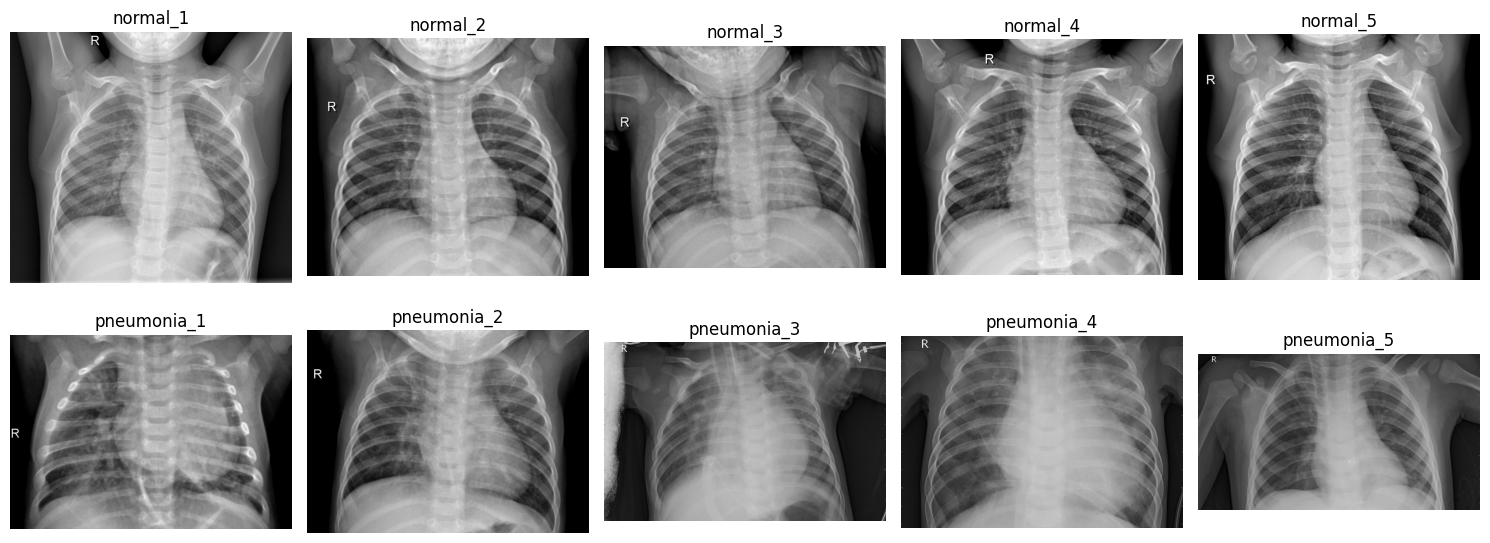

In [4]:
import os
from PIL import Image
import matplotlib.pyplot as plt

data_dir = "/content/drive/MyDrive/chest_xray_samples"
normal_dir = os.path.join(data_dir, "normal")
pneumonia_dir = os.path.join(data_dir, "pneumonia")

images = {}

normal_files = sorted([f for f in os.listdir(normal_dir) if f.endswith(('.jpeg', '.jpg', '.png'))])[:5]
for i, f in enumerate(normal_files):
    name = f"normal_{i+1}"
    images[name] = {"path": os.path.join(normal_dir, f), "image": Image.open(os.path.join(normal_dir, f)).convert("RGB"), "condition": "normal"}

pneumonia_files = sorted([f for f in os.listdir(pneumonia_dir) if f.endswith(('.jpeg', '.jpg', '.png'))])[:5]
for i, f in enumerate(pneumonia_files):
    name = f"pneumonia_{i+1}"
    images[name] = {"path": os.path.join(pneumonia_dir, f), "image": Image.open(os.path.join(pneumonia_dir, f)).convert("RGB"), "condition": "pneumonia"}

print(f"loaded {len(images)} images")

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for name, data in images.items():
    row = 0 if "normal" in name else 1
    col = int(name.split("_")[1]) - 1
    axes[row, col].imshow(data["image"], cmap='gray')
    axes[row, col].set_title(name)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

# **Prompts**

In [5]:
def get_prompts(condition):
    if condition == "normal":
        return [
            ("Is there pneumonia in this X-ray?", False, "affirmative"),
            ("Is there a pleural effusion in this X-ray?", False, "affirmative"),
            ("Is there no pneumonia in this X-ray?", True, "negated"),
            ("Is there no pleural effusion in this X-ray?", True, "negated"),
            # ("Is there right-sided pneumonia?", False, "left_right"),
            # ("Is there left-sided pneumonia?", False, "left_right"),
        ]
    else:
        return [
            ("Is there pneumonia in this X-ray?", True, "affirmative"),
            ("Is there consolidation in this X-ray?", True, "affirmative"),
            ("Is there no pneumonia in this X-ray?", False, "negated"),
            ("Is there no lung abnormality in this X-ray?", False, "negated"),
            # ("Is there right-sided pneumonia?", True, "left_right"),
            # ("Is there left-sided pneumonia?", True, "left_right"),
        ]

all_test_cases = []
for img_name, data in images.items():
    for prompt, expected, prompt_type in get_prompts(data["condition"]):
        all_test_cases.append({
            "image_name": img_name,
            "prompt": prompt,
            "ground_truth": expected,
            "prompt_type": prompt_type,
            "condition": data["condition"],
        })

print(f"total: {len(all_test_cases)} test cases")
print(f"affirmative: {sum(1 for x in all_test_cases if x['prompt_type'] == 'affirmative')}")
print(f"negated: {sum(1 for x in all_test_cases if x['prompt_type'] == 'negated')}")
print(f"left_right: {sum(1 for x in all_test_cases if x['prompt_type'] == 'left_right')}")

total: 40 test cases
affirmative: 20
negated: 20
left_right: 0


# **LLaVA-Med**

In [15]:
from transformers import AutoProcessor, AutoModelForVision2Seq
import torch
from tqdm import tqdm
import pandas as pd
from PIL import Image

# Load model and processor
processor = AutoProcessor.from_pretrained("chaoyinshe/llava-med-v1.5-mistral-7b-hf")
model = AutoModelForVision2Seq.from_pretrained(
    "chaoyinshe/llava-med-v1.5-mistral-7b-hf",
    torch_dtype=torch.float16,
    device_map="auto"
)

processor_config.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/auto/modeling_auto.py:2284: FutureWarning: The class `AutoModelForVision2Seq` is deprecated and will be removed in v5.0. Please use `AutoModelForImageTextToText` instead.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

model-00004-of-00004.safetensors:   0%|          | 0.00/380M [00:00<?, ?B/s]

model-00003-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00002-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

model-00001-of-00004.safetensors:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/136 [00:00<?, ?B/s]

In [17]:
def parse_model_response(response, prompt):
    """
    Determine if model affirmed the finding.
    Returns: (model_said_yes: bool, extracted_answer: str)
    """
    response_lower = response.lower()

    # Check for explicit negations first
    negations = ["no", "not visible", "not present", "absent", "cannot see",
                 "no evidence", "negative", "no sign"]
    if any(neg in response_lower for neg in negations):
        return False, response

    # Check for affirmations
    affirmations = ["yes", "present", "visible", "detected", "observed",
                    "shows", "demonstrates", "there is"]
    if any(aff in response_lower for aff in affirmations):
        return True, response

    # Default to uncertain
    return None, response

# Run inference on all test cases
results = []

for test_case in tqdm(all_test_cases, desc="Running LLaVA-Med inference"):
    # Load image
    image_path = images[test_case["image_name"]]["path"]
    image = Image.open(image_path)

    # Create prompt
    prompt = f"USER: <image>\n{test_case['prompt']}\nASSISTANT:"

    # Prepare inputs
    inputs = processor(
        text=prompt,
        images=image,
        return_tensors="pt",
        padding=True
    ).to(model.device)

    # Generate WITH scores
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        return_dict_in_generate=True,
        output_scores=True
    )

    # Get confidence scores
    transition_scores = model.compute_transition_scores(
        outputs.sequences,
        outputs.scores,
        normalize_logits=True
    )
    mean_confidence = transition_scores.mean().item()

    # Decode response
    response = processor.decode(outputs.sequences[0], skip_special_tokens=True)

    # Parse response
    model_said_yes, extracted = parse_model_response(response, test_case['prompt'])

    # Determine if correct
    is_correct = (model_said_yes == test_case['ground_truth']) if model_said_yes is not None else False

    # Store results
    results.append({
        **test_case,
        "response": response,
        "extracted_answer": extracted,
        "confidence": mean_confidence,
        "model_said_yes": model_said_yes,
        "is_correct": is_correct,
        "is_false_positive": (model_said_yes and not test_case['ground_truth']),
    })

    # Clear cache to avoid OOM
    torch.cuda.empty_cache()

# Convert to DataFrame
df_llava = pd.DataFrame(results)
df_llava.to_csv("llava_med_results.csv", index=False)

# Print summary
print("\n" + "="*60)
print("LLaVA-Med Results Summary")
print("="*60)

print(f"\nOverall accuracy: {df_llava['is_correct'].mean():.2%}")

# False premise detection
false_premises = df_llava[df_llava['ground_truth'] == False]
print(f"\nFalse Premise Performance:")
print(f"  Total false premises: {len(false_premises)}")
print(f"  Model said 'Yes' (false positives): {false_premises['model_said_yes'].sum()}")
print(f"  False positive rate: {false_premises['model_said_yes'].mean():.2%}")

# Confidence comparison
print(f"\nConfidence Scores (Mean Log-Probability):")
print(f"  True cases: {df_llava[df_llava['ground_truth']==True]['confidence'].mean():.3f}")
print(f"  False premises: {df_llava[df_llava['ground_truth']==False]['confidence'].mean():.3f}")

# By prompt type
print(f"\nPerformance by Prompt Type:")
for ptype in df_llava['prompt_type'].unique():
    subset = df_llava[df_llava['prompt_type'] == ptype]
    print(f"  {ptype}: {subset['is_correct'].mean():.2%} accuracy")

print("\n" + "="*60)

# Display first few results
print("\nFirst 5 test cases:")
print(df_llava[['image_name', 'prompt', 'ground_truth', 'model_said_yes', 'confidence', 'is_correct']].head())

Running LLaVA-Med inference: 100%|██████████| 40/40 [06:01<00:00,  9.05s/it]


LLaVA-Med Results Summary

Overall accuracy: 40.00%

False Premise Performance:
  Total false premises: 20
  Model said 'Yes' (false positives): 5
  False positive rate: 25.00%

Confidence Scores (Mean Log-Probability):
  True cases: -0.246
  False premises: -0.265

Performance by Prompt Type:
  affirmative: 30.00% accuracy
  negated: 50.00% accuracy


First 5 test cases:
  image_name                                       prompt  ground_truth  \
0   normal_1            Is there pneumonia in this X-ray?         False   
1   normal_1   Is there a pleural effusion in this X-ray?         False   
2   normal_1         Is there no pneumonia in this X-ray?          True   
3   normal_1  Is there no pleural effusion in this X-ray?          True   
4   normal_2            Is there pneumonia in this X-ray?         False   

   model_said_yes  confidence  is_correct  
0           False   -0.294713        True  
1            True   -0.215857       False  
2           False   -0.238694       False

In [19]:
import numpy as np

df_llava = pd.DataFrame(results)

# Add probability column (convert from log-probability)
df_llava['confidence_prob'] = np.exp(df_llava['confidence'])

# Reorder columns to put them side by side
cols = df_llava.columns.tolist()
confidence_idx = cols.index('confidence')
cols.insert(confidence_idx + 1, cols.pop(cols.index('confidence_prob')))
df_llava = df_llava[cols]

# Rename for clarity
df_llava = df_llava.rename(columns={'confidence': 'confidence_logprob'})

df_llava.to_csv("llava_med_results.csv", index=False)

# Display sample to verify
print("\nConfidence columns:")
print(df_llava[['prompt', 'confidence_logprob', 'confidence_prob', 'model_said_yes']].head())


Confidence columns:
                                        prompt  confidence_logprob  \
0            Is there pneumonia in this X-ray?           -0.294713   
1   Is there a pleural effusion in this X-ray?           -0.215857   
2         Is there no pneumonia in this X-ray?           -0.238694   
3  Is there no pleural effusion in this X-ray?           -0.213626   
4            Is there pneumonia in this X-ray?           -0.290809   

   confidence_prob  model_said_yes  
0         0.744745           False  
1         0.805851            True  
2         0.787656           False  
3         0.807650           False  
4         0.747658           False  


In [23]:
df_llava

,image_name,prompt,ground_truth,prompt_type,condition,response,extracted_answer,confidence_logprob,confidence_prob,model_said_yes,is_correct,is_false_positive
0,normal_1,Is there pneumonia in this X-ray?,False,affirmative,normal,USER: \nIs there pneumonia in this X-ray?\nASS...,USER: \nIs there pneumonia in this X-ray?\nASS...,-0.294713,0.744745,False,True,False
1,normal_1,Is there a pleural effusion in this X-ray?,False,affirmative,normal,USER: \nIs there a pleural effusion in this X-...,USER: \nIs there a pleural effusion in this X-...,-0.215857,0.805851,True,False,True
2,normal_1,Is there no pneumonia in this X-ray?,True,negated,normal,USER: \nIs there no pneumonia in this X-ray?\n...,USER: \nIs there no pneumonia in this X-ray?\n...,-0.238694,0.787656,False,False,False
3,normal_1,Is there no pleural effusion in this X-ray?,True,negated,normal,USER: \nIs there no pleural effusion in this X...,USER: \nIs there no pleural effusion in this X...,-0.213626,0.807650,False,False,False
4,normal_2,Is there pneumonia in this X-ray?,False,affirmative,normal,USER: \nIs there pneumonia in this X-ray?\nASS...,USER: \nIs there pneumonia in this X-ray?\nASS...,-0.290809,0.747658,False,True,False
5,normal_2,Is there a pleural effusion in this X-ray?,False,affirmative,normal,USER: \nIs there a pleural effusion in this X-...,USER: \nIs there a pleural effusion in this X-...,-0.274169,0.760204,True,False,True
6,normal_2,Is there no pneumonia in this X-ray?,True,negated,normal,USER: \nIs there no pneumonia in this X-ray?\n...,USER: \nIs there no pneumonia in this X-ray?\n...,-0.242784,0.784441,False,False,False
7,normal_2,Is there no pleural effusion in this X-ray?,True,negated,normal,USER: \nIs there no pleural effusion in this X...,USER: \nIs there no pleural effusion in this X...,-0.229382,0.795025,False,False,False
8,normal_3,Is there pneumonia in this X-ray?,False,affirmative,normal,USER: \nIs there pneumonia in this X-ray?\nASS...,USER: \nIs there pneumonia in this X-ray?\nASS...,-0.291904,0.746840,False,True,False
9,normal_3,Is there a pleural effusion in this X-ray?,False,affirmative,normal,USER: \nIs there a pleural effusion in this X-...,USER: \nIs there a pleural effusion in this X-...,-0.233742,0.791566,True,False,True


In [28]:
df_llava.iloc[1]['extracted_answer']

'USER: \nIs there a pleural effusion in this X-ray?\nASSISTANT: Yes, there appears to be a right-sided pleural effusion in the chest X-ray. '


AGGREGATED CONFIDENCE SCORES

Mean Log-Probability (aggregated over all response tokens):
  Positive/True cases (ground_truth=True):  -0.2460
  Negative/False premises (ground_truth=False): -0.2645
  Difference: 0.0186

Mean Probability (converted):
  Positive/True cases:  0.7824
  Negative/False premises: 0.7678

Sample sizes:
  True cases: n=20
  False premises: n=20


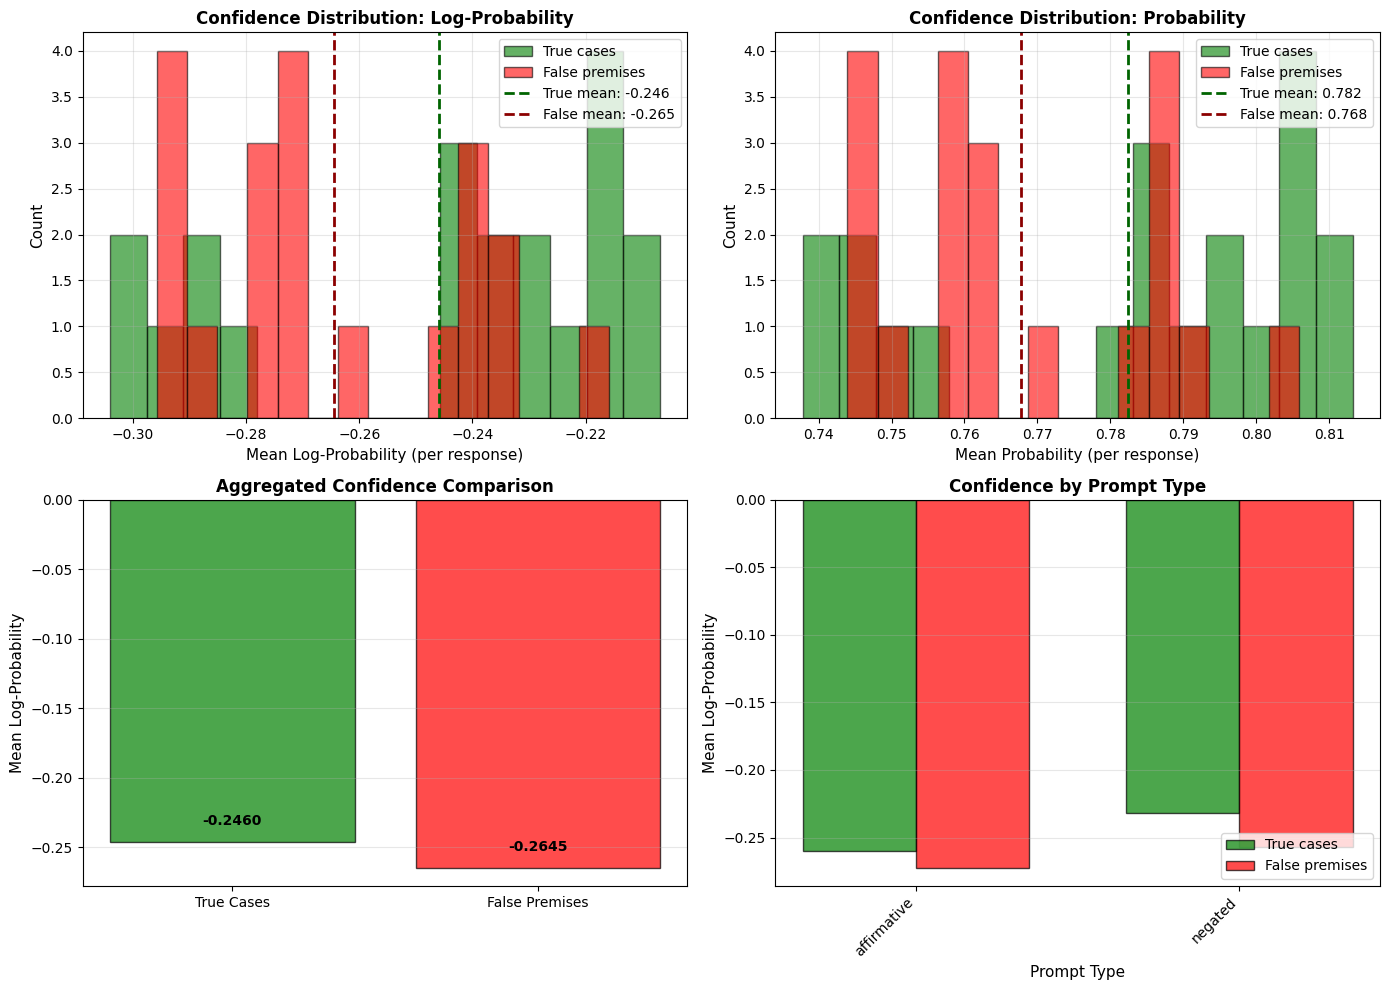


✓ Figure saved as 'llava_med_confidence_analysis.png'


In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Calculate aggregated scores
true_cases = df_llava[df_llava['ground_truth'] == True]
false_premises = df_llava[df_llava['ground_truth'] == False]

print("\n" + "="*60)
print("AGGREGATED CONFIDENCE SCORES")
print("="*60)

print("\nMean Log-Probability (aggregated over all response tokens):")
print(f"  Positive/True cases (ground_truth=True):  {true_cases['confidence_logprob'].mean():.4f}")
print(f"  Negative/False premises (ground_truth=False): {false_premises['confidence_logprob'].mean():.4f}")
print(f"  Difference: {true_cases['confidence_logprob'].mean() - false_premises['confidence_logprob'].mean():.4f}")

print("\nMean Probability (converted):")
print(f"  Positive/True cases:  {true_cases['confidence_prob'].mean():.4f}")
print(f"  Negative/False premises: {false_premises['confidence_prob'].mean():.4f}")

print(f"\nSample sizes:")
print(f"  True cases: n={len(true_cases)}")
print(f"  False premises: n={len(false_premises)}")

# Create histogram figure
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Log-probability distribution
ax1 = axes[0, 0]
ax1.hist(true_cases['confidence_logprob'], alpha=0.6, label='True cases', bins=15, color='green', edgecolor='black')
ax1.hist(false_premises['confidence_logprob'], alpha=0.6, label='False premises', bins=15, color='red', edgecolor='black')
ax1.axvline(true_cases['confidence_logprob'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'True mean: {true_cases["confidence_logprob"].mean():.3f}')
ax1.axvline(false_premises['confidence_logprob'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'False mean: {false_premises["confidence_logprob"].mean():.3f}')
ax1.set_xlabel('Mean Log-Probability (per response)', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Confidence Distribution: Log-Probability', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# 2. Probability distribution
ax2 = axes[0, 1]
ax2.hist(true_cases['confidence_prob'], alpha=0.6, label='True cases', bins=15, color='green', edgecolor='black')
ax2.hist(false_premises['confidence_prob'], alpha=0.6, label='False premises', bins=15, color='red', edgecolor='black')
ax2.axvline(true_cases['confidence_prob'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'True mean: {true_cases["confidence_prob"].mean():.3f}')
ax2.axvline(false_premises['confidence_prob'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'False mean: {false_premises["confidence_prob"].mean():.3f}')
ax2.set_xlabel('Mean Probability (per response)', fontsize=11)
ax2.set_ylabel('Count', fontsize=11)
ax2.set_title('Confidence Distribution: Probability', fontsize=12, fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)

# 3. Bar chart comparison
ax3 = axes[1, 0]
categories = ['True Cases', 'False Premises']
logprob_means = [true_cases['confidence_logprob'].mean(), false_premises['confidence_logprob'].mean()]
bars = ax3.bar(categories, logprob_means, color=['green', 'red'], alpha=0.7, edgecolor='black')
ax3.set_ylabel('Mean Log-Probability', fontsize=11)
ax3.set_title('Aggregated Confidence Comparison', fontsize=12, fontweight='bold')
ax3.grid(axis='y', alpha=0.3)
# Add value labels on bars
for i, (bar, val) in enumerate(zip(bars, logprob_means)):
    ax3.text(bar.get_x() + bar.get_width()/2, val + 0.01, f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. By prompt type
ax4 = axes[1, 1]
prompt_types = df_llava['prompt_type'].unique()
true_by_type = [df_llava[(df_llava['prompt_type']==pt) & (df_llava['ground_truth']==True)]['confidence_logprob'].mean()
                for pt in prompt_types]
false_by_type = [df_llava[(df_llava['prompt_type']==pt) & (df_llava['ground_truth']==False)]['confidence_logprob'].mean()
                 for pt in prompt_types]

x = np.arange(len(prompt_types))
width = 0.35
ax4.bar(x - width/2, true_by_type, width, label='True cases', color='green', alpha=0.7, edgecolor='black')
ax4.bar(x + width/2, false_by_type, width, label='False premises', color='red', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Prompt Type', fontsize=11)
ax4.set_ylabel('Mean Log-Probability', fontsize=11)
ax4.set_title('Confidence by Prompt Type', fontsize=12, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(prompt_types, rotation=45, ha='right')
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('llava_med_confidence_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as 'llava_med_confidence_analysis.png'")

In [32]:
import seaborn as sns

print("=" * 60)
print("HALLUCINATION ANALYSIS")
print("=" * 60)

print(f"\noverall accuracy: {df_llava['is_correct'].mean() * 100:.1f}%")

print("\nby prompt type:")
for ptype in df_llava["prompt_type"].unique():
    subset = df_llava[df_llava["prompt_type"] == ptype]
    acc = subset["is_correct"].mean() * 100
    print(f"  {ptype}: {acc:.1f}%")

# Hallucination = model says YES when ground truth is FALSE
false_premises = df_llava[df_llava["ground_truth"] == False]
hallucinations = false_premises[false_premises["model_said_yes"] == True]
halluc_rate = (len(hallucinations) / len(false_premises) * 100) if len(false_premises) > 0 else 0

print(f"\nhallucination analysis:")
print(f"  total false premise questions: {len(false_premises)}")
print(f"  model said 'yes' to false premise: {len(hallucinations)}")
print(f"  hallucination rate: {halluc_rate:.1f}%")

# Breakdown by prompt type for false premises
print("\nhallucination by prompt type:")
for ptype in df_llava["prompt_type"].unique():
    fp_subset = df_llava[(df_llava["prompt_type"] == ptype) & (df_llava["ground_truth"] == False)]
    if len(fp_subset) > 0:
        halluc_subset = fp_subset[fp_subset["model_said_yes"] == True]
        print(f"  {ptype}: {len(halluc_subset)}/{len(fp_subset)} = {len(halluc_subset)/len(fp_subset)*100:.1f}%")

print("\nlog-probability:")
correct = df_llava[df_llava["is_correct"] == True]["confidence_logprob"]
incorrect = df_llava[df_llava["is_correct"] == False]["confidence_logprob"]
print(f"  correct: {correct.mean():.4f}")
print(f"  incorrect: {incorrect.mean():.4f}")
print(f"  difference: {abs(correct.mean() - incorrect.mean()):.4f}")

print("\nconfidence on hallucinations vs correct responses:")
if len(hallucinations) > 0:
    halluc_conf = hallucinations["confidence_logprob"].mean()
    correct_conf = df_llava[df_llava["is_correct"] == True]["confidence_logprob"].mean()
    print(f"  hallucinations: {halluc_conf:.4f}")
    print(f"  correct responses: {correct_conf:.4f}")
    print(f"  difference: {abs(halluc_conf - correct_conf):.4f}")

HALLUCINATION ANALYSIS

overall accuracy: 40.0%

by prompt type:
  affirmative: 30.0%
  negated: 50.0%

hallucination analysis:
  total false premise questions: 20
  model said 'yes' to false premise: 5
  hallucination rate: 25.0%

hallucination by prompt type:
  affirmative: 5/10 = 50.0%
  negated: 0/10 = 0.0%

log-probability:
  correct: -0.2695
  incorrect: -0.2458
  difference: 0.0237

confidence on hallucinations vs correct responses:
  hallucinations: -0.2519
  correct responses: -0.2695
  difference: 0.0176


# **MiniGPT-Med**
*(still not working due to some dependencies issue)*

In [33]:
# Clone the repository
!git clone https://github.com/Vision-CAIR/MiniGPT-Med.git
%cd MiniGPT-Med

# Install dependencies
!pip install -r requirements.txt
!pip install -e .

# Additional packages
!pip install salesforce-lavis
!pip install iopath
!pip install torch torchvision torchaudio

Cloning into 'MiniGPT-Med'...
remote: Enumerating objects: 418, done.
remote: Counting objects: 100% (418/418), done.
remote: Compressing objects: 100% (321/321), done.
remote: Total 418 (delta 109), reused 353 (delta 59), pack-reused 0 (from 0)
Receiving objects: 100% (418/418), 4.52 MiB | 11.68 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/MiniGPT-Med
ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'
Obtaining file:///content/MiniGPT-Med
ERROR: file:///content/MiniGPT-Med does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.4/235.4 kB 8.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.4 MB/s eta

In [35]:
!pip install -q huggingface_hub

In [ ]:
from huggingface_hub import snapshot_download

snapshot_download(
    repo_id="meta-llama/Llama-2-7b-chat-hf",
    local_dir="./llama2",
    use_auth_token=HF_TOKEN
)

Fetching 16 files:   0%|          | 0/16 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/22.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.52k [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

LICENSE.txt:   0%|          | 0.00/7.02k [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/188 [00:00<?, ?B/s]

USE_POLICY.md:   0%|          | 0.00/4.77k [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

'/content/MiniGPT-Med/llama2'

In [37]:
# Update paths in config files
import yaml

# Update eval config
with open('eval_configs/minigptv2_eval.yaml', 'r') as f:
    eval_config = yaml.safe_load(f)

eval_config['model']['ckpt'] = '/content/miniGPT_Med.pth'

with open('eval_configs/minigptv2_eval.yaml', 'w') as f:
    yaml.dump(eval_config, f)

# Update model config
with open('minigpt4/configs/models/minigpt_v2.yaml', 'r') as f:
    model_config = yaml.safe_load(f)

model_config['model']['llama_model'] = '/content/MiniGPT-Med/llama2'

with open('minigpt4/configs/models/minigpt_v2.yaml', 'w') as f:
    yaml.dump(model_config, f)

In [3]:
# Uninstall conflicting packages
!pip uninstall -y transformers peft bitsandbytes accelerate torch torchvision torchaudio

# Install exact versions from environment.yml
!pip install torch==2.0.0 torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install transformers==4.30.0
!pip install peft==0.2.0
!pip install bitsandbytes==0.37.0
!pip install accelerate==0.20.3
!pip install huggingface-hub==0.18.0
!pip install timm==0.6.13
!pip install webdataset==0.2.48
!pip install omegaconf==2.3.0
!pip install opencv-python==4.7.0.72
!pip install decord==0.6.0
!pip install gradio==3.47.1
!pip install sentence-transformers
!pip install scikit-image

print("✓ All dependencies installed!")

Found existing installation: transformers 4.57.3
Uninstalling transformers-4.57.3:
  Successfully uninstalled transformers-4.57.3
Found existing installation: peft 0.2.0
Uninstalling peft-0.2.0:
  Successfully uninstalled peft-0.2.0
Found existing installation: accelerate 1.12.0
Uninstalling accelerate-1.12.0:
  Successfully uninstalled accelerate-1.12.0
Found existing installation: torch 2.9.1
Uninstalling torch-2.9.1:
  Successfully uninstalled torch-2.9.1
Looking in indexes: https://download.pytorch.org/whl/cu118
ERROR: Could not find a version that satisfies the requirement torch==2.0.0 (from versions: 2.2.0+cu118, 2.2.1+cu118, 2.2.2+cu118, 2.3.0+cu118, 2.3.1+cu118, 2.4.0+cu118, 2.4.1+cu118, 2.5.0+cu118, 2.5.1+cu118, 2.6.0+cu118, 2.7.0+cu118, 2.7.1+cu118)
ERROR: No matching distribution found for torch==2.0.0
  Using cached transformers-4.30.0-py3-none-any.whl.metadata (113 kB)
  Using cached tokenizers-0.13.3.tar.gz (314 kB)
  Installing build dependencies ... done
  Getting requi

  Using cached bitsandbytes-0.37.0-py3-none-any.whl.metadata (7.7 kB)
Using cached bitsandbytes-0.37.0-py3-none-any.whl (76.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 7.8 MB/s eta 0:00:00
  Attempting uninstall: accelerate
    Found existing installation: accelerate 1.12.0
    Uninstalling accelerate-1.12.0:
      Successfully uninstalled accelerate-1.12.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 11.4 MB/s eta 0:00:00
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.36.0
    Uninstalling huggingface-hub-0.36.0:
      Successfully uninstalled huggingface-hub-0.36.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-clip-torch 3.2.0 requires torchvision, which is not installed.
timm 1.0.22 requires torchvision, which is not installed.
transformers 4.57.3 requires huggingface-hub<1

  Using cached huggingface_hub-1.2.3-py3-none-any.whl.metadata (13 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.18.0
    Uninstalling huggingface-hub-0.18.0:
      Successfully uninstalled huggingface-hub-0.18.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
open-clip-torch 3.2.0 requires timm>=1.0.17, but you have timm 0.6.13 which is incompatible.
✓ All dependencies installed!


In [1]:
%cd MiniGPT-Med

/content/MiniGPT-Med


In [2]:
import torch
from minigpt4.common.config import Config
from minigpt4.common.registry import registry
from minigpt4.conversation.conversation import Chat, CONV_VISION_minigptv2
from PIL import Image
from tqdm import tqdm
import pandas as pd

# Load configuration and model
cfg = Config(Config.parse_args())
cfg.cfg_path = "eval_configs/minigptv2_eval.yaml"

model_config = cfg.model_cfg
model_config.device_8bit = 0
model_cls = registry.get_model_class(model_config.arch)

model = model_cls.from_config(model_config).to('cuda:0')
model.eval()

# Load visual processor
vis_processor_cfg = cfg.datasets_cfg.cc_sbu_align.vis_processor.train
vis_processor = registry.get_processor_class(vis_processor_cfg.name).from_config(vis_processor_cfg)

# Initialize chat
chat = Chat(model, vis_processor, device='cuda:0')

def parse_model_response(response, prompt):
    """Determine if model affirmed the finding."""
    response_lower = response.lower()

    negations = ["no", "not visible", "not present", "absent", "cannot see",
                 "no evidence", "negative", "no sign", "does not show"]
    if any(neg in response_lower for neg in negations):
        return False, response

    affirmations = ["yes", "present", "visible", "detected", "observed",
                    "shows", "demonstrates", "there is", "can see"]
    if any(aff in response_lower for aff in affirmations):
        return True, response

    return None, response

# Run inference on all test cases
results_minigpt = []

for test_case in tqdm(all_test_cases, desc="Running MiniGPT-Med inference"):
    # Load image
    image_path = images[test_case["image_name"]]["path"]
    image = Image.open(image_path).convert('RGB')

    # Create new conversation state
    chat_state = CONV_VISION_minigptv2.copy()
    img_list = []

    # Upload image
    chat.upload_img(image, chat_state, img_list)

    # Ask question
    chat.ask(test_case['prompt'], chat_state)

    # Generate response
    response = chat.answer(
        conv=chat_state,
        img_list=img_list,
        num_beams=1,
        temperature=1.0,
        max_new_tokens=300,
        max_length=2000
    )[0]

    # Parse response
    model_said_yes, extracted = parse_model_response(response, test_case['prompt'])
    is_correct = (model_said_yes == test_case['ground_truth']) if model_said_yes is not None else False

    # Store results
    results_minigpt.append({
        **test_case,
        "response": response,
        "extracted_answer": extracted,
        "model_said_yes": model_said_yes,
        "is_correct": is_correct,
        "is_false_positive": (model_said_yes and not test_case['ground_truth']),
    })

    # Clear for next iteration
    torch.cuda.empty_cache()

# Convert to DataFrame
df_minigpt = pd.DataFrame(results_minigpt)
df_minigpt.to_csv("minigpt_med_results.csv", index=False)

# Print summary
print("\n" + "="*60)
print("MiniGPT-Med Results Summary")
print("="*60)
print(f"\nTotal test cases: {len(df_minigpt)}")
print(f"Overall accuracy: {df_minigpt['is_correct'].mean():.2%}")

false_premises = df_minigpt[df_minigpt['ground_truth'] == False]
print(f"\nFalse Premise Performance:")
print(f"  Total false premises: {len(false_premises)}")
print(f"  Model said 'Yes' (false positives): {false_premises['model_said_yes'].sum()}")
print(f"  False positive rate: {false_premises['model_said_yes'].mean():.2%}")


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA_SETUP: WARNING! libcudart.so not found in any environmental path. Searching /usr/local/cuda/lib64...
CUDA SETUP: CUDA runtime path found: /usr/local/cuda/lib64/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.5
CUDA SETUP: Detected CUDA version 125
CUDA SETUP: Required library version not found: libbitsandbytes_cuda125.so. Maybe you need to compile it from source?
CUDA SETUP: Defaulting to libbitsandbytes_cpu.so...

================================================ERROR=====================================
CUDA SETUP: CUDA detection failed! Possible reasons:
1. CUDA driver not installed
2. CUDA not installed
3. You have multiple conflicting CUDA libraries
4. Required library not pre-compiled for this bitsandbytes release!
CUDA SETUP: If you compiled 

/usr/local/lib/python3.12/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/usr/local/lib/python3.12/dist-packages/cv2/../../lib64')}
  warn(msg)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: /usr/local/lib/python3.12/dist-packages/cv2/../../lib64:/usr/lib64-nvidia did not contain libcudart.so as expected! Searching further paths...
  warn(msg)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('/sys/fs/cgroup/memory.events /var/colab/cgroup/jupyter-children/memory.events')}
  warn(msg)
/usr/local/lib/python3.12/dist-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: The following directories listed in your path were found to be non-existent: {PosixPath('https'), PosixPath('//mp.ka

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 0>:2                                                                              │
│                                                                                                  │
│     1 import torch                                                                               │
│ ❱   2 from minigpt4.common.config import Config                                                  │
│     3 from minigpt4.common.registry import registry                                              │
│     4 from minigpt4.conversation.conversation import Chat, CONV_VISION_minigptv2                 │
│     5 from PIL import Image                                                                      │
│                                                                                                  │
│ /content/MiniGPT-Med/minigpt4/__init__.py:16 in <module>                                         │
│                                                                                                  │
│   13 from minigpt4.common.registry import registry                                               │
│   14                                                                                             │
│   15 from minigpt4.datasets.builders import *                                                    │
│ ❱ 16 from minigpt4.models import *                                                               │
│   17 from minigpt4.processors import *                                                           │
│   18 from minigpt4.tasks import *                                                                │
│   19                                                                                             │
│                                                                                                  │
│ /content/MiniGPT-Med/minigpt4/models/__init__.py:13 in <module>                                  │
│                                                                                                  │
│    10 from omegaconf import OmegaConf                                                            │
│    11                                                                                            │
│    12 from minigpt4.common.registry import registry                                              │
│ ❱  13 from minigpt4.models.base_model import BaseModel                                           │
│    14 from minigpt4.models.minigpt_base import MiniGPTBase                                       │
│    15 from minigpt4.models.minigpt4 import MiniGPT4                                              │
│    16 from minigpt4.models.minigpt_v2 import MiniGPTv2                                           │
│                                                                                                  │
│ /content/MiniGPT-Med/minigpt4/models/base_model.py:17 in <module>                                │
│                                                                                                  │
│    14 import torch                                                                               │
│    15 import torch.nn as nn                                                                      │
│    16 from transformers import LlamaTokenizer                                                    │
│ ❱  17 from peft import (                                                                         │
│    18 │   LoraConfig,                                                                            │
│    19 │   get_peft_model,                                                                        │
│    20 )                                                                                          │
│                                                                                                  │
│ /usr/local/lib/python3.12/dist-packages/peft/__init__.py:22

# **BiomedCLIP Similarity**

In [3]:
!pip install open_clip_torch

import torch
import open_clip
from PIL import Image
import pandas as pd
from tqdm import tqdm

model_name = 'hf-hub:microsoft/BiomedCLIP-PubMedBERT_256-vit_base_patch16_224'
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(model_name)
tokenizer = open_clip.get_tokenizer(model_name)

model = model.cuda()
model.eval()

print("✓ BiomedCLIP loaded successfully!")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 52.3 MB/s eta 0:00:00
  Attempting uninstall: timm
    Found existing installation: timm 0.6.13
    Uninstalling timm-0.6.13:
      Successfully uninstalled timm-0.6.13


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


open_clip_config.json:   0%|          | 0.00/707 [00:00<?, ?B/s]

open_clip_pytorch_model.bin:   0%|          | 0.00/784M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

✓ BiomedCLIP loaded successfully!


In [7]:
# Run similarity check on all test cases
biomedclip_results = []

for test_case in tqdm(all_test_cases, desc="Running BiomedCLIP similarity"):
    # Load and preprocess image
    image_path = images[test_case["image_name"]]["path"]
    image = Image.open(image_path).convert('RGB')
    image_input = preprocess_val(image).unsqueeze(0).cuda()

    # Extract medical finding from prompt for better matching
    # E.g., "Is there pneumonia?" -> "pneumonia"
    # For simplicity, use the full prompt
    text = test_case['prompt']
    text_input = tokenizer([text]).cuda()

    # Compute similarity
    with torch.no_grad(), torch.cuda.amp.autocast():
        image_features = model.encode_image(image_input)
        text_features = model.encode_text(text_input)

        # Normalize
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        text_features = text_features / text_features.norm(dim=-1, keepdim=True)

        # Cosine similarity
        similarity = (image_features @ text_features.T).squeeze().item()

    biomedclip_results.append({
        **test_case,
        "biomedclip_similarity": similarity
    })

# Convert to DataFrame
df_biomedclip = pd.DataFrame(biomedclip_results)
df_biomedclip.to_csv("biomedclip_results.csv", index=False)

# Analysis
print("\n" + "="*60)
print("BIOMEDCLIP SIMILARITY ANALYSIS")
print("="*60)

true_cases = df_biomedclip[df_biomedclip['ground_truth'] == True]
false_premises = df_biomedclip[df_biomedclip['ground_truth'] == False]

print(f"\nMean Similarity Scores:")
print(f"  True cases: {true_cases['biomedclip_similarity'].mean():.4f}")
print(f"  False premises: {false_premises['biomedclip_similarity'].mean():.4f}")
print(f"  Difference: {true_cases['biomedclip_similarity'].mean() - false_premises['biomedclip_similarity'].mean():.4f}")

print(f"\nBy prompt type:")
for ptype in df_biomedclip['prompt_type'].unique():
    subset_true = df_biomedclip[(df_biomedclip['prompt_type']==ptype) & (df_biomedclip['ground_truth']==True)]
    subset_false = df_biomedclip[(df_biomedclip['prompt_type']==ptype) & (df_biomedclip['ground_truth']==False)]
    if len(subset_true) > 0 and len(subset_false) > 0:
        print(f"  {ptype}: True={subset_true['biomedclip_similarity'].mean():.4f}, False={subset_false['biomedclip_similarity'].mean():.4f}")

Running BiomedCLIP similarity:   0%|          | 0/40 [00:00<?, ?it/s]/tmp/ipython-input-2986670750.py:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast():
Running BiomedCLIP similarity: 100%|██████████| 40/40 [00:03<00:00, 11.42it/s]


BIOMEDCLIP SIMILARITY ANALYSIS

Mean Similarity Scores:
  True cases: 0.3820
  False premises: 0.3692
  Difference: 0.0128

By prompt type:
  affirmative: True=0.3707, False=0.3677
  negated: True=0.3932, False=0.3707


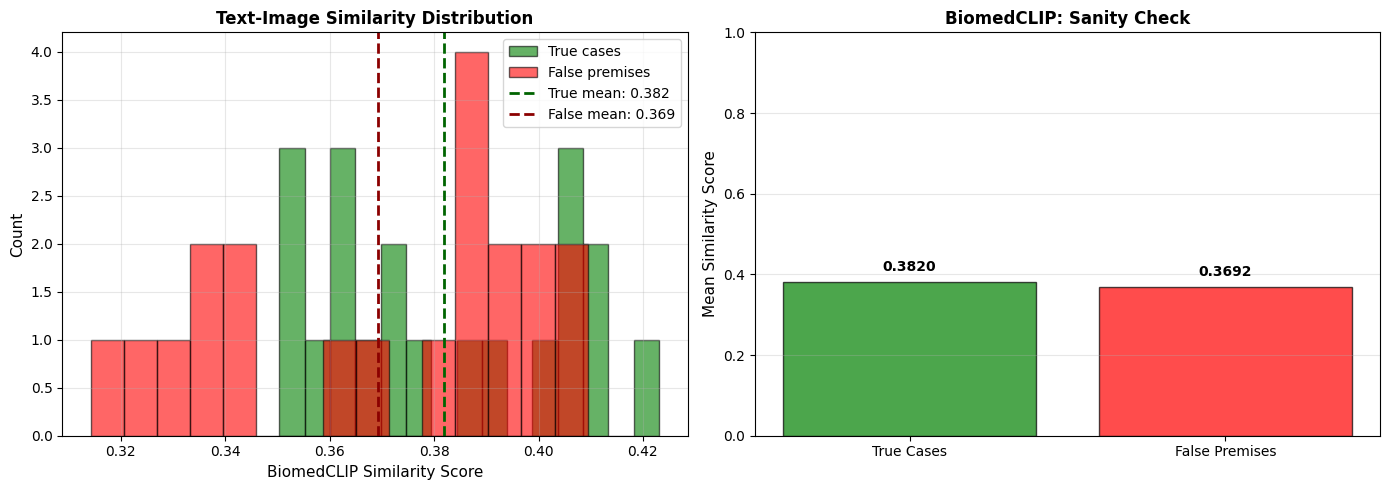


✓ Figure saved as 'biomedclip_sanity_check.png'


In [8]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
ax1.hist(true_cases['biomedclip_similarity'], alpha=0.6, label='True cases', bins=15, color='green', edgecolor='black')
ax1.hist(false_premises['biomedclip_similarity'], alpha=0.6, label='False premises', bins=15, color='red', edgecolor='black')
ax1.axvline(true_cases['biomedclip_similarity'].mean(), color='darkgreen', linestyle='--', linewidth=2, label=f'True mean: {true_cases["biomedclip_similarity"].mean():.3f}')
ax1.axvline(false_premises['biomedclip_similarity'].mean(), color='darkred', linestyle='--', linewidth=2, label=f'False mean: {false_premises["biomedclip_similarity"].mean():.3f}')
ax1.set_xlabel('BiomedCLIP Similarity Score', fontsize=11)
ax1.set_ylabel('Count', fontsize=11)
ax1.set_title('Text-Image Similarity Distribution', fontsize=12, fontweight='bold')
ax1.legend()
ax1.grid(alpha=0.3)

# Bar chart comparison
ax2 = axes[1]
categories = ['True Cases', 'False Premises']
similarity_means = [true_cases['biomedclip_similarity'].mean(), false_premises['biomedclip_similarity'].mean()]
bars = ax2.bar(categories, similarity_means, color=['green', 'red'], alpha=0.7, edgecolor='black')
ax2.set_ylabel('Mean Similarity Score', fontsize=11)
ax2.set_title('BiomedCLIP: Sanity Check', fontsize=12, fontweight='bold')
ax2.set_ylim([0, 1])
ax2.grid(axis='y', alpha=0.3)
for bar, val in zip(bars, similarity_means):
    ax2.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.4f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('biomedclip_sanity_check.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Figure saved as 'biomedclip_sanity_check.png'")